In [1]:
#import statements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# import string
# from sklearn.preprocessing import LabelEncoder
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# from nltk.corpus import stopwords
# sw = (stopwords.words('english'))
# import nltk
# from nltk.tag import pos_tag
# from nltk.tokenize import RegexpTokenizer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import pickle

In [2]:
#Read in the lemmtized data
smallData = pd.read_csv("lemmatizedArticles.csv")

In [3]:
#Use only articles of sizable length
minLemmaLen = 100
smallerData = smallData[smallData["len"]>minLemmaLen]

In [4]:
#Split articles into their respective bias categories
vr = smallerData[smallerData["Rating"]==2]
sr = smallerData[smallerData["Rating"]==1]
c = smallerData[smallerData["Rating"]==0]
sl = smallerData[smallerData["Rating"]==-1]
vl = smallerData[smallerData["Rating"]==-2]
print("Number of Very Right articles: ",len(vr))
print("Number of Slightly Right articles: ",len(sr))
print("Number of Center Articles: ",len(c))
print("Number of Slightly Left articles: ",len(sl))
print("Number of Very Left articles: ",len(vl))


Number of Very Right articles:  51111
Number of Slightly Right articles:  39317
Number of Center Articles:  21734
Number of Slightly Left articles:  32076
Number of Very Left articles:  28862


In [5]:
#Get an equal subset from each category
sn=min(len(vr),len(sr),len(c),len(sl),len(vl))
newData = pd.concat([vr.sample(n=sn),sr.sample(n=sn),c.sample(n=sn),sl.sample(n=sn),vl.sample(n=sn)])
print("Total number of articles analyzed: ",len(newData)," (",len(newData)/5," per category )")

Total number of articles analyzed:  108670  ( 21734.0  per category )


In [6]:
#Function to rejoin all our lemmatized words into a string
def proc(tex):
    return " ".join(tex)

#Get our X values and y values. 
X = newData['lemText']
#First, try to put all articles in the proper of the 5 categories
y = (newData['Rating'])

In [25]:
#Bag of words analysis
#Create analyzer
transModel = CountVectorizer()
transModel.fit(X) #fit it
bow_transformer=transModel.transform(X)
X_train, X_test, y_train, y_test = train_test_split(bow_transformer, y
                                  ,test_size=0.1, random_state=1234) #Split into training and test sets
pickle.dump(transModel,open('countVectorizerModel.sav','wb')) #Save vectorizer

In [49]:
#Create small subsets to optimize parameters on; create X_small_train and X_small_test,
#Both about 1% of the total dataset
X_temp, X_small_train, y_temp, y_small_train = train_test_split(X_train, y_train
                                  ,test_size=0.01, random_state=123)
_, X_small_test, _, y_small_test = train_test_split(X_temp, y_temp
                                  ,test_size=0.01, random_state=123)

['successful', 'military', 'campaign', 'bring', 'swift', 'justice', 'leader', 'al', 'clearly', 'big', 'big', 'victory', 'surrender', 'world', 'wanted', 'terrorist', 'tugged', 'suicide', 'vest', 'blew', 'piece', 'made', 'sure', 'blast', 'killed', 'child', 'medium', 'coverage', 'easily', 'predicted', 'news', 'disappeared', 'absolutely', 'everything', 'need', 'put', 'political', 'filter', 'took', 'bin', 'journalist', 'hailed', 'proven', 'master', 'commander', 'simply', 'true', 'nothing', 'proven', 'military', 'prowess', 'tell', 'friend', 'tried', 'tried', 'one', 'courage', 'gut', 'coolness', 'took', 'chance', 'oozed', 'turned', 'ran', 'incredible', 'incredible', 'raid', 'wrote', 'columnist', 'proved', 'vividly', 'almost', 'biblical', 'term', 'effective', 'commander', 'chief', 'gushed', 'supportive', 'respected', 'military', 'spin', 'elimination', 'al', 'also', 'predictable', 'journalist', 'pundit', 'gritted', 'teeth', 'acknowledged', 'mission', 'reflected', 'well', 'approving', 'mission',

AttributeError: values not found

In [ ]:
#Scan grid of parameters to find optimal values for C and Gamma
firstBestScore = 0
firstBestC = 0
firstBestGamma = 0
for C in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]:
    for gamma in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]:
        print(C,gamma)
        model = svm.SVC(C=C, kernel='rbf', gamma=gamma)
        model.fit(X_small_train, y_small_train)
        score = model.score(X_small_test, y_small_test)
        
        if score > firstBestScore:
            firstBestC = C
            firstBestGamma = gamma
            firstBestScore = score
            print("*"+str(score))
        else:
            print(score)
print("--------")
print("Best C value: ",firstBestC)
print("Best Gamma value: ",firstBestGamma)
print("Best score: ", firstBestScore)

In [8]:
#Fit the model to the full data set
model = svm.SVC(C=firstBestC, kernel='rbf', gamma=firstBestGamma)
model.fit(X_train, y_train)

SVC(C=10, gamma=1e-05)

In [9]:
print(model.score(X_test,y_test))

0.3965215790926659


              precision    recall  f1-score   support

          -2       0.41      0.45      0.43      2238
          -1       0.36      0.43      0.39      2141
           0       0.41      0.45      0.43      2181
           1       0.42      0.27      0.33      2120
           2       0.39      0.38      0.39      2187

    accuracy                           0.40     10867
   macro avg       0.40      0.40      0.39     10867
weighted avg       0.40      0.40      0.39     10867

Confusion Matrix:
[[0.44906166 0.17873101 0.15370867 0.09785523 0.12064343]
 [0.18075666 0.42503503 0.15600187 0.09294722 0.14525922]
 [0.15222375 0.16276937 0.45483723 0.08344796 0.14672169]
 [0.17264151 0.21839623 0.16462264 0.27169811 0.17264151]
 [0.15820759 0.18015546 0.18838592 0.0955647  0.37768633]]


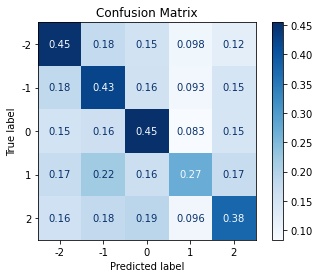

In [10]:
predictions = model.predict(X_test)
# getting the Precision, Recall, F1-Score
print(classification_report(y_test,predictions))
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=[-2,-1,0,1,2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
title="Confusion Matrix"
disp.ax_.set_title(title)

print(title+":")
print(disp.confusion_matrix)


In [11]:
#Save the model
pickle.dump(model,open('fullyTrainedModel.sav','wb'))


In [24]:
print(bow_transformer.size)
print(X_train.size)
model.predict(X_test[:10])

3442040
3098128


array([ 0, -2,  2,  0, -1,  0,  0,  2, -2, -2])

Normalized confusion matrix
[[0.43269231 0.20192308 0.16346154 0.13461538 0.06730769]
 [0.1547619  0.42857143 0.17857143 0.08333333 0.1547619 ]
 [0.12087912 0.14285714 0.48351648 0.0989011  0.15384615]
 [0.15730337 0.17977528 0.19101124 0.34831461 0.12359551]
 [0.19626168 0.25233645 0.09345794 0.14018692 0.31775701]]


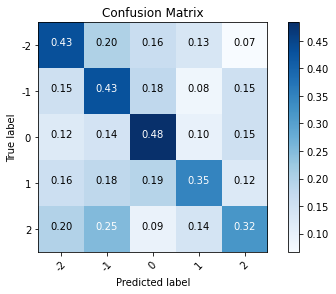